In [7]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

For example, we generate below several sequences of 2-qubit Clifford circuits.

**Step 1: Generate RB Seqeunces**

In [17]:
# Generate RB circuits (2Q RB)

# number of qubits
nQ = 2 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
# Number of seeds (random sequences)
rb_opts['nseeds'] = 5
# Default pattern
rb_opts['rb_pattern'] = [[0, 1]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [18]:
rb_circs[0][0].draw()

┌───┐               ┌─────┐┌───┐     ┌───┐┌───┐      ░      ┌─────┐┌───┐»
qr_0: ┤ Z ├────────────■──┤ Sdg ├┤ H ├──■──┤ H ├┤ S ├──■───░───■──┤ Sdg ├┤ H ├»
      ├───┤┌───┐┌───┐┌─┴─┐├─────┤├───┤┌─┴─┐├───┤├───┤┌─┴─┐ ░ ┌─┴─┐├─────┤├───┤»
qr_1: ┤ X ├┤ H ├┤ S ├┤ X ├┤ Sdg ├┤ H ├┤ X ├┤ H ├┤ S ├┤ X ├─░─┤ X ├┤ Sdg ├┤ H ├»
      └───┘└───┘└───┘└───┘└─────┘└───┘└───┘└───┘└───┘└───┘ ░ └───┘└─────┘└───┘»
cr: 2/════════════════════════════════════════════════════════════════════════»
                                                                              »
«           ┌───┐┌───┐      ┌───┐      ┌─┐        
«qr_0: ──■──┤ H ├┤ S ├──■───┤ Z ├──────┤M├────────
«      ┌─┴─┐├───┤├───┤┌─┴─┐┌┴───┴┐┌───┐└╥┘┌───┐┌─┐
«qr_1: ┤ X ├┤ H ├┤ S ├┤ X ├┤ Sdg ├┤ H ├─╫─┤ X ├┤M├
«      └───┘└───┘└───┘└───┘└─────┘└───┘ ║ └───┘└╥┘
«cr: 2/═════════════════════════════════╩═══════╩═
«                                       0       1

One can verify that the Unitary representing each RB circuit should be the identity (with a global phase). We simulate this using Aer simulator.

In [19]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [20]:
# The Unitary is an identity (with a global phase)
sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc.save_unitary()
unitary = sim.run(qc).result().get_unitary()
from qiskit.visualization import array_to_latex
array_to_latex(unitary, prefix="\\text{Unitary} = ")

<IPython.core.display.Latex object>

**Step 2: Execute the RB sequences (with some noise)**

In [21]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('aer_simulator')

**Step 3, 4 and 5**

As an example, we calculate the average sequence fidelity for each of the RB sequences, fit the results to the exponential curve, and compute the parameters α and EPC.

In [22]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs):
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.978314, EPC: 0.016265
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.980560, EPC: 0.014580
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.981276, EPC: 0.014043
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.979111, EPC: 0.015667
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.979078, EPC: 0.015692


**Plot the results**

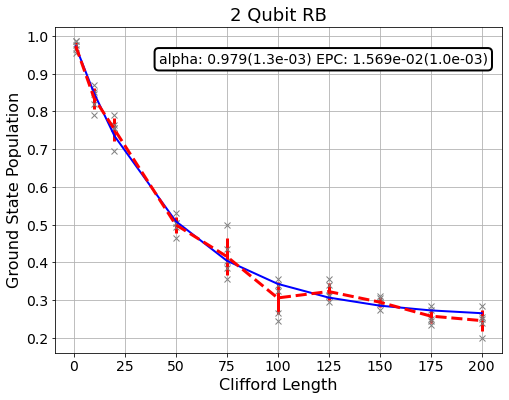

In [23]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

# Predicting Gate Fidelity

If we know the errors on the underlying gates (the gateset) we can predict the EPC without running RB experiment. This calculation verifies that your RB experiment followed by fitting yields correct EPC value. First we need to count the number of these gates per Clifford.

Then, the two qubit Clifford gate error function calculate_2q_epc gives the error per 2Q Clifford. It assumes that the error in the underlying gates is depolarizing.

In [24]:
# count the number of single and 2Q gates in the 2Q Cliffords
qubits = rb_opts['rb_pattern'][0]

gate_per_cliff = rb.rb_utils.gates_per_clifford(
    transpiled_circuits_list=transpiled_circs_list,
    clifford_lengths=xdata[0],
    basis=basis_gates,
    qubits=qubits)

for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f"%(
        basis_gate,
        np.mean([gate_per_cliff[qubit][basis_gate] for qubit in qubits])))

Number of u1 gates per Clifford: 0.120415
Number of u2 gates per Clifford: 1.633188
Number of u3 gates per Clifford: 0.184498
Number of cx gates per Clifford: 1.501310


In [25]:
# convert from depolarizing error to epg (1Q)
epg_q0 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}
epg_q1 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}

# convert from depolarizing error to epg (2Q)
epg_q01 = 3/4 * p2Q

# calculate the predicted epc from underlying gate errors 
pred_epc = rb.rb_utils.calculate_2q_epc(
    gate_per_cliff=gate_per_cliff,
    epg_2q=epg_q01,
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per Clifford: %e (aer simulator result: %e)" % (pred_epc, rb_fit.fit[0]['epc']))

Predicted 2Q Error per Clifford: 1.595387e-02 (aer simulator result: 1.569158e-02)


On the other hand, we can calculate the errors on the underlying gates (the gateset) from the experimentally obtained EPC. Given that we know the errors on the every single-qubit gates in the RB sequence, we can predict 2Q gate error from the EPC of two qubit RB experiment.

The two qubit gate error function calculate_2q_epg gives the estimate of error per 2Q gate. In this section we prepare single-qubit errors using the deporalizing error model. If the error model is unknown, EPGs of those gates, for example [u1, u2, u3], can be estimated with a separate 1Q RB experiment with the utility function calculate_1q_epg

In [26]:
# use 2Q EPC from aer simulator result and 1Q EPGs from depolarizing error model
pred_epg = rb.rb_utils.calculate_2q_epg(
    gate_per_cliff=gate_per_cliff,
    epc_2q=rb_fit.fit[0]['epc'],
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per gate: %e (gate error model: %e)" % (pred_epg, epg_q01))

Predicted 2Q Error per gate: 7.305337e-03 (gate error model: 7.500000e-03)
